# Вступ

В темі 6 *Виявлення аномалій в даних великої розмірності* ми дізналися, що дані великої розмірності створюють додаткові ускладнення для виявлення аномалій («прокляття розмірності»). Ми також обговорили два підходи до виявлення аномалій у високих вимірах: метод підпростору з пакетуванням ознак і ізольованими лісами.

Тут буде використано як метод підпростору, так і ізоляційні ліси для виявлення аномалій у багатовимірних змодельованих наборах даних.


# Результати навчання

Ви повинні мати:
1. Розуміння проблем виявлення аномалій за допомогою даних великої розмірності
2. Деякий практичний досвід використання методу підпростору та пакетування ознак
3. Деякий практичний досвід роботи із ізольованими лісами

# Імпорт

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import sys
import datetime
import scipy
import scipy.stats as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import IsolationForest

---

# Розділ 1: Метод підпростору з пакетуванням ознак

У цьому розділі ми збираємося використовувати змодельовані дані, щоб проілюструвати метод підпростору з пакетуванням функцій.

Наш підхід ґрунтуватиметься на ранній публікації щодо виявлення аномалій за допомогою методу підпростору з пакетуванням ознак (A. Lazarevic і V. Kumar. Feature Bagging for Outlier Detection. Конференція ACM KDD, 2005). Це є
доступно тут: https://www.researchgate.net/profile/Vipin-Kumar-54/publication/221653185_Feature_bagging_for_outlier_detection/links/0deec517946e6823b2000000/Feature-bagging-for-outlier-detection.pdf?_tp=eyJjb250ZXh0Ijp7ImZpcnN0UGFnZSI6InB1YmxpY2F0aW9uIiwicGFnZSI6InB1YmxpY2F0aW9uIn19

Ми будемо діяти наступним чином:

1. Створіть змодельовані дані
2. Виконайте виявлення аномалії за допомогою методу subspace/feature bagging
3. Оцініть результати
4. Проаналізуйте результат за допомогою матриці помилок

### Data

Ми починаємо зі створення даних, які будуть комбінацією нормальних точок і аномалій для загальної кількості 5100 точок. 5000 нормальних точок генеруються з 5D-розподілу Гауса, де ми вказуємо середнє значення в кожному вимірі, а також коваріаційну матрицю. Аномалії — це 100 точок, які знаходяться далеко від нормальних точок у тому самому 5D-просторі (відповідні особливості). Щоб дослідити вплив пакетування функцій, до всіх точок даних додається додатковий 5D шум (нерелевантні функції).

Спочатку ми згенеруємо 5000 звичайних точок даних

In [ ]:
np.random.seed(20) # зафіксувати для відтворюваності

# генерувати звичайні дані, використовуючи кількість точок,
# кількість відповідних ознак, середнє та стандартне відхилення
norm_pts = 5000
norm_dim = 5
norm_mean = 0.0
norm_stdev = 0.5
norm_data = np.random.normal(norm_mean, norm_stdev,
                             (norm_pts, norm_dim))

#Примітка:
#
# Не плутайте два  слова «normal»
# «normal» у np.random.multivariate_normal стосується
# до розподілу Гаусса і взагалі не пов’язаний
# до норми відносно аномалії

Далі ми генеруємо аномальні дані. Ми зробимо це в два кроки:

A. Створіть гаусівський розподіл точок

B. Перетворіть цей розподіл у кільце навколо нормальних точок.

In [ ]:
# Створіть розподіл Гауса для попередніх даних про аномалії
# використовуючи кількість точок, кількість відповідних ознак,
# середнє та стандартне відхилення
anom_pts = 100
anom_dim = 5
anom_mean = 0.0
anom_stdev = 0.5
anom_data_prelim = np.random.normal(anom_mean, anom_stdev,
                             (anom_pts, anom_dim))

In [ ]:
# Перетворення в кільцевий розподіл для остаточних даних аномалії
def transform_to_ring(data, radius, spread):
    """
    Перетворює надані дані в кільцевий розподіл.
     ---
     Inputs: дані (дані для перетворення, np.array),
     radius (радіус кільця, float)
     spread (розкид даних про радіус, float)
     Outputs: перетворені дані (np.array)
    """
    transformed_data_list = []
    for item in data:
        z = np.array(item) # у випадку, якщо дані надаються у вигляді списку
        transformed_data_list.append(z*spread
                                     + radius*z / np.linalg.norm(z))
        transformed_data = np.array(transformed_data_list)
    return transformed_data



In [5]:
anom_data = transform_to_ring(anom_data_prelim, 2.0, 1.0)

Побудуйте графік даних, (нормальний і аномальний)

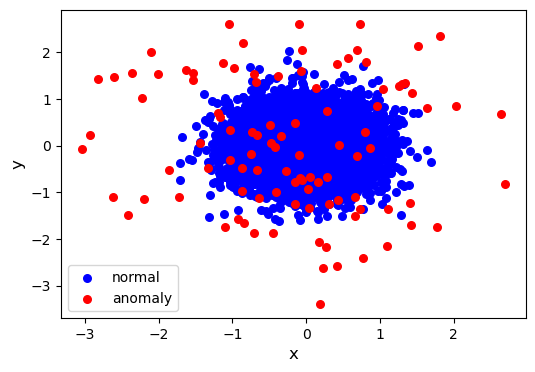

In [ ]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)

ax1.scatter(norm_data[:,0], norm_data[:,1], s=30, c='b', marker="o",
            label='normal')
ax1.scatter(anom_data[:,0], anom_data[:,1], s=30, c='r', marker="o",
            label='anomaly')
plt.legend(loc='best');
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.show()

Оскільки ми будуємо 5D-розподіл у 2D, важко побачити кільцеву природу даних аномалії.

**Питання**: як ми можемо швидко перевірити, чи працює наше кільцеве перетворення?

**Відповідь**: подивіться на аномалії у 2D. Встановіть параметр *anom_dim* на 2 і дослідіть, що відбувається, коли ви змінюєте *radius* і *spread*.

In [7]:
# Об’єднайте дані в один масив для подальшого використання
combined_data = np.concatenate((norm_data, anom_data), axis=0)
combined_data.shape

(5100, 5)

In [ ]:
# Створення шуму для нормальних даних (1) і аномалій (2)
# використання ряду невідповідних функцій,
# середнє та стандартне відхилення
noise_dim = 5
noise_mean = 0
noise_stdev = 4
noise_norm = np.random.normal(noise_mean, noise_stdev,
                                    (norm_pts, noise_dim))
noise_anom = np.random.normal(noise_mean, noise_stdev,
                                    (anom_pts, noise_dim )) #створюємо шум


In [9]:
# Додати шум до нормальних даних і аномалій
# для створення повних даних (усі ознаки)
norm_data_full = np.concatenate((norm_data, noise_norm), axis=1)
anom_data_full = np.concatenate((anom_data, noise_anom), axis=1)

In [10]:
# Агрегувати нормальні дані та аномалії для подальшого використання
all_data = np.concatenate((norm_data_full, anom_data_full), axis=0)

### Виявлення аномалій із пакетуванням ознак

Нагадування про те, як пакетування ознак працює в розмірах $d$:
    
1. Навмання виберіть ціле число $m$ від $\lfloor{d/2}\rfloor$ до $d-1$
2. Для кожної ітерації вибирайте $m$ ознак випадковим чином без заміни з повного набору даних, створюючи $m$-вимірну підмножину
3. Застосуйте алгоритм виявлення аномалії до підмножини, щоб оцінити кожну точку даних
4. Об’єднайте оцінки з різних ітерацій, щоб отримати загальний результат для кожної точки


Почніть із визначення функції для виконання кроків 1 і 2.

In [ ]:
def feature_bagging(data):
    """
    Вибирає дані підпростору за допомогою пакетування ознак.

     Args:
         data: повні дані для вибірки (np.array)

     Returns:
         subspace_data: дані підпростору (np.array)
    """
    # Знайдіть розмір повного простору
    full_dim = data.shape[1]
    # виберіть розмір підпростору
    size_subspace = np.random.randint(full_dim // 2, full_dim - 1)
    # вибрати ознаки без заміни
    subspace_index = np.random.choice(full_dim, size_subspace,
                                      replace=False) # дає масив індексів без повторень

    # вибрати дані підпростору
    # Спочатку обознаки  являють собою стовпці даних
    # Транспонувати, щоб вибрати ознаки у вигляді рядків (простіше)
    # а потім перенести назад, щоб відновити ознаки у вигляді стовпців
    subspace_data = (data.T[sorted(subspace_index),:]).T
    return subspace_data

Виконайте виявлення аномалії на даних підпростору (крок 3). Ми будемо використовувати підхід локального викиду (LOF), який обговорювався в темі 5. LOF також використовувався Лазаревичем і Кумаром, оскільки він повертає відповідним чином нормалізовані оцінки, які враховують підпростори ознак різних вимірів.

Щоб об’єднати оцінки з кожної ітерації (крок 4), ми використаємо підхід кумулятивної суми (див. тему 5).

In [ ]:
def anomaly_subspace_method(data, repeat):
    """
    Виконує виявлення аномалій за допомогою пакетування ознак.
     Використовує локальний фактор викиду (LOF) для виявлення аномалії.
     Використовує кумулятивний підхід для об’єднання результатів виявлення аномалій.
     з кожної ітерації

    Args:
        data: повні дані для вибірки (np.array)
        repeat: кількість ітерацій для пакетування функцій (int)
     Returns:
        final_scores: оцінки аномалії кожної точки в даних (list)
    """
    final_scores = np.zeros(len(data))
    for i in range(repeat):
        subspace_data = feature_bagging(data)
        clf = LocalOutlierFactor(n_neighbors=20, metric='manhattan')
        y_pred = clf.fit_predict(subspace_data)
        X_scores = clf.negative_outlier_factor_
        final_scores += X_scores
    return final_scores


**Примітка**. Ми використовуємо *negative_outlier_factor_* оцінку *sklearn*:

Inliers, як правило, мають *negative_outlier_factor_* близький до -1.
Викиди, як правило, мають велике від’ємне число.

Дивіться також Лекцію 04 і http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html

Тепер настав час проаналізувати дані. Ми повторимо цю функцію 50 разів.

In [13]:
cumulative_scores = anomaly_subspace_method(all_data, 10)

In [14]:
cumulative_scores.shape

(5100,)

We know that the first 5000 points are normal data and the next 100 are anomalies. Therefore we expect that the scores at the beginning of *cumulative_scores* should be less negative than those at the end.

In [15]:
print(cumulative_scores[0:20])

[-10.42822032 -10.11430337  -9.94264351  -9.97740891 -11.35658359
 -10.65692172 -10.59557416 -11.89593756 -10.3129885  -10.14233905
 -12.02322703 -10.52378682 -10.10541638 -10.96957967 -10.63905103
 -10.36021459  -9.92217649 -10.67933135 -10.98069907 -11.39922243]


In [16]:
print(cumulative_scores[5080:5100]) #більш негативні оцінки - це аномалії

[-14.85215851 -14.21291428 -15.21692821 -15.68583487 -16.28738734
 -15.99495715 -16.38737843 -14.46308237 -14.99386485 -16.59273306
 -11.95628822 -15.18960334 -15.72579168 -14.53332571 -22.4328569
 -15.98863141 -14.32595071 -14.94775829 -15.18901059 -14.30024492]


Виглядає розумно, але з такою кількістю точок даних ми повинні вийти за рамки простих перевірок і провести деякий статистичний аналіз.

Оскільки передбачені аномалії матимуть найнижчі оцінки, то ми сортуємо оцінки від низької до високої та повертаємо індекс кожної відповідної точки даних.

In [17]:
ranking_by_index = np.argsort(cumulative_scores)

Знову ж таки, давайте швидко перевіримо.

In [18]:
print(ranking_by_index[0:20]) #індекси з найбільши відємними оцінками

[5094 5028 5067 5079 5052 5054 5062 5077 5050 5089 5006 5020 1128 5009
 5053 5086 5084 5048 5016 5042]


Більшість із 20 точок із найнижчими оцінками мають індекси 5000 і більше.

Щоб створити матрицю помилок, ми створимо два масиви: один із справжніми мітками для кожної точки, а інший із передбаченими мітками. Ми будемо використовувати 1 для аномалій і 0 для нормальних точок.

In [19]:
# Створення міток на основі відомих даних
# Ми знаємо, що перші *norm_pts* є нормальними даними (0)
# і наступні *anom_pts* є аномаліями (1)
label_true = [0]*norm_pts
for i in range(anom_pts):
        label_true.append(1)# Масив міток: перші 5000 з нулями, а решта 100 з одиницями


Ми отримуємо передбачені мітки за допомогою *ranking_by_index*. Оскільки ми знаємо, що маємо 100 аномалій, ми позначимо перші 100 найнижчих показників як аномалії, а решту – як нормальні дані. (Щоб бути більш загальним, ми будемо використовувати параметр *anom_pts* замість числа).

In [ ]:
label_pred = [0]*len(all_data)
for index, item in enumerate(ranking_by_index):
    label_pred[item] = 1 #першим 100 присвоїти 1, бо вони впорядковані за спаданням оцінки і є аномаліями
    if index == anom_pts:
        # Ми зупиняємося, коли маємо мітки *anom_pts* точок
        break

Тепер, коли у нас є мітки, ми можемо побудувати матрицю помилок. Один із способів зробити це — датафрейми pandas.

In [21]:
label_true_series = pd.Series(label_true, name='True')
label_pred_series = pd.Series(label_pred, name='Predicted')
df_confusion_matrix = pd.crosstab(label_true_series, label_pred_series)
df_confusion_matrix

Predicted,0,1
True,,
0,4985,15
1,14,86


Ми правильно знайшли 86 із 100 аномалій, а також знайшли 4985 із 5000 нормальних точок даних.

Крім того, ми можемо використовувати scikit-learn.

In [22]:
# Див. розділ «Імпорт» вище
confusion_matrix(label_true, label_pred)

array([[4985,   15],
       [  14,   86]], dtype=int64)

Перевага scikit-learn полягає в тому, що він має багато корисних функцій для оцінки різних статистичних показників ефективності. Наприклад, ми можемо обчислити точність, яка є часткою справжніх результатів (істинно позитивних, і справді негативних) від загальної кількості проаналізованих точок.

In [23]:
accuracy_score(label_true, label_pred)

0.994313725490196

Для отримання додаткових інформації див. http://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics

Схоже, ми створили чудовий детектор аномалій, але ми повинні пам’ятати, що ми мали значну допомогу: ми включили кількість аномалій (але не їх ідентичність) у процедуру оцінки. Якби ми не знали, скільки у нас аномалій, виявлення аномалій стало б складнішим.

(І дивіться Тему 7 для обговорення обмежень точності як метрики для алгоритмів виявлення аномалій.)

Крім того, було кілька параметрів, які ми повинні були вибрати: *повторити* для кількості разів для перенесення або функції упаковки; *n_neighbors* і *metric* для оцінки LOF. Існують емпіричні правила вибору цих параметрів, але часто потрібна дослідницька робота, щоб знайти відповідні значення для поточної проблеми.

# Розділ 2: Ізоляційні ліси


У цьому розділі ми збираємося вивчити ізольовані ліси, використовуючи ті самі змодельовані дані, які ми аналізували за допомогою методу підпростору.

Ми будемо діяти так само, як і з методом підпростору:

1. Створіть змодельовані дані — **уже зроблено**
2. Виконайте виявлення аномалії за допомогою алгоритму ізольованого лісу
3. Оцініть результати
4. Проаналізуйте результат за допомогою матриці помилок

### Виявлення аномалій за допомогою ізольованого лісу

Нагадування про те, як працює ізоляційний ліс:


<li> Це метод ансамблю: ізольований ліс — це комбінація ізольованих дерев.</li>

<li> Щоб створити ізольоване дерево, об’єкт вибирається випадковим чином, а дані повторно розділяються за допомогою осепаралельних розрізів у випадково вибраних положеннях.</li>

<li> Цей процес повторюється з метою розділити дані на вузли з дедалі меншою кількістю точок, доки не буде досягнуто єдиного вузла, що містить одну точку («лист» дерева).</li>

<li> Ми очікуємо, що гілки дерева, які містять аномалії, будуть менш глибокими, ніж гілки звичайних точок, оскільки аномалії розташовані в розріджених областях.</li>

<li>Отже, глибина гілки може бути використана для оцінки точки на листі. </li>
    
<li>Цей процес повторюється для попередньо визначеної кількості дерев, щоб обчислити середню оцінку аномалії.</li>

<li>Потім ця остаточна оцінка порівнюється з пороговим значенням, щоб позначити точку як нормальний показник або аномалію.</li>


Більш детальна інформація доступна в публікаціях оригінальних авторів цієї методики (F.L. Kai, M. Ting і Z.-H. Zhou):
https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/tkdd11.pdf
 

Ми будемо використовувати реалізацію ізольованого лісу sklearn, яка включає алгоритм виявлення, а також процедуру підрахунку оцінок (кроки 2 і 3 у процесі, описаному в попередньому підрозділі):

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

Ця реалізація використовує іншу конвенцію оцінювання, ніж оригінальна публікація Кая, Тінга та Чжоу. У версії sklearn негативні оцінки представляють аномалії, позитивні – нормальні дані. (Для даної точки, чим негативніший результат, тим більшою є аномалія.)

Існує кілька ключових параметрів для IsolationForest, алгоритму sklearn. Якщо доступний навчальний набір даних, цей набір даних можна використовувати для налаштування цих параметрів. У нашому випадку ми не маємо навчального набору даних, тому ми використовуватимемо розумні (за замовчуванням) значення, як описано нижче.

Спочатку давайте створимо наш ліс.

In [ ]:
isolation_forest = IsolationForest(n_estimators=100, max_samples=256,
                                   contamination=0.01961, max_features=10)

Пояснення параметрів:
    
1. *n_estimators*: кількість ізольованих дерев у лісі. Значення за замовчуванням — 100.

2. *max_samples*: це максимальна кількість точок, взятих для побудови кожного дерева. Sklearn пропонує кілька варіантів для цього параметра. Кай, Тін і Чжоу вважають, що 256 «загалом достатньо, щоб
виконувати виявлення аномалій у широкому діапазоні даних".

3. *max_features*: кількість елементів, намальованих для побудови кожного дерева. Тут ми використовуємо повну розмірність нашого набору даних (10). Використання меншого значення призведе до створення пакетів ознак у дереві.

4. *забруднення*: частка точок, які є аномаліями. Так само, як ми робили для методу підпростору, ми будемо використовувати це число для позначення аномалій. Надане число (*anom_pts*)/(*anom_pts* + *norm_pts*) = 100/5100.

Тепер, коли ми створили ліс, ми можемо підігнати наші дані та отримати оцінки точок. Щоб зробити це належним чином, ми повинні побудувати дерево з навчальним набором даних, а потім застосувати це дерево до тестових даних. Ви зробите це у вправі 2 нижче.

Наразі ми скористаємося спрощеним підходом і підберемо дерево та отримати оцінки точок, використовуючи ті самі дані. Це невибагливий підхід до ізольованого лісу, який може призвести до упереджених результатів, але він забезпечує більш справедливе порівняння з методом підпростору (де немає поділу поїзд/тест).

In [25]:
isolation_forest.fit(all_data)
anomaly_score = isolation_forest.decision_function(all_data)

Як і з методом підпростору, ми знаємо, що перші 5000 точок є нормальними даними, а наступні 100 – аномаліями. Таким чином, ми очікуємо, що оцінки на початку *anomaly_scores* мають бути позитивними, а наприкінці – негативними.

In [26]:
print(anomaly_score[0:20])

[0.10735375 0.12133362 0.1301514  0.14338582 0.04792288 0.09559621
 0.05899167 0.05914986 0.08257227 0.11723036 0.03874564 0.08471182
 0.10655479 0.06857933 0.08208751 0.09561946 0.15434401 0.08015293
 0.08243244 0.06645808]


In [27]:
print(anomaly_score[5080:5100])

[-0.04914545 -0.04655918 -0.02274752 -0.06293287 -0.07434275 -0.00712662
  0.00478768  0.0076357   0.04715734 -0.06804756  0.04316677 -0.01748935
  0.03398974  0.01248265 -0.11357263  0.00331218  0.03067255  0.00409005
  0.02213045  0.05059864]


Ми бачимо деякі позитивні оцінки в кінці, але було б багато чого просити, щоб наш ізольований ліс був ідеальним. Якими будуть останні 100 балів за прогнозом *IsolationForest*?

**Примітка**: *IsolationForest* позначає аномалії -1, а нормальні точки - +1.

In [28]:
pred_forest = isolation_forest.predict(all_data)

In [29]:
print(pred_forest[5000:5100])

[-1 -1  1  1 -1  1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1  1  1  1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1  1  1 -1 -1  1  1 -1 -1 -1 -1  1  1
 -1 -1 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1  1 -1
  1  1  1  1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1  1 -1  1  1 -1  1
  1  1  1  1]


Добре, що в у більшості маємо -1, але нам слід підрахувати точну статистику. Щоб зробити чітке порівняння з результатами нашого підпросторового методу, ми перетворимо *pred_forest* на угоду про маркування, яку ми використовували раніше: аномалії дорівнюють +1, а нормальні точки даних дорівнюють 0.

In [ ]:
label_pred_forest = pred_forest
# normal data label switched from 1 to 0
label_pred_forest [label_pred_forest > 0] = 0
# anomaly label switched from -1 to 1
label_pred_forest [label_pred_forest < 0] = 1

In [31]:
confusion_matrix(label_true, label_pred_forest)

array([[4961,   39],
       [  39,   61]], dtype=int64)

In [32]:
accuracy_score(label_true, label_pred_forest)

0.9847058823529412

Коли ми дивимося на матрицю помилок, ми бачимо, що вона має менше справжніх позитивних результатів, ніж метод підпростору. Тим не менш, це популярний метод через свою швидкість (низька складність обчислень).

### Вправа №1

Ця вправа відноситься до Розділу 1 (метод підпростору з пакетуванням ознак).

Ми збираємося проаналізувати дані без будь-якого пакетування функцій і перевірити, чи правильне твердження, яке ми зробили на лекціях: пакетування функцій покращує виявлення аномалій

A. Змініть *anomaly_subspace_method*, щоб здійснювати виявлення аномалій на повних даних без будь-якого пакетування функцій.

B. Визначити матрицю помилок.

C. Як результати порівнюються з методом підпростору?


### Рішення #1

In [ ]:
def anomaly_subspace_method2(data):
    # here you code


    return final_scores

(5100,)

[5094 5028 1128 3701 1810 3422 5079 4584 4712 5084 5044  678 5077 5042
 1775 2715 5059 3533 1507 4386]


In [ ]:
label_pred2 =
# here you code


In [38]:
confusion_matrix(label_true, label_pred2)

array([[4929,   71],
       [  70,   30]], dtype=int64)

In [39]:
accuracy_score(label_true, label_pred2)

0.9723529411764706

### Вправа №2

Ця вправа відноситься до розділу 2 (ізоляційні ліси).

A. Створіть навчальний набір даних. Він має мати ті самі функції, що й *all_data*, за винятком того, що він має відрізнятися від точок і мати одну п’яту розміру (20 аномалій і 1000 нормальних точок).


B. Навчіть ізольований ліс на цьому наборі даних, а потім протестуйте навчений ліс на *all_data*.

C. Порівняйте результати для матриці помилок з тими, які ви отримали без поділу на test/train. Обговоріть будь-які відмінності.


### Рішення #2

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
# here you code

In [42]:
# here you code

In [43]:
all_data_train.shape

(1020, 10)

In [ ]:
isolation_forest =

# here you code

In [46]:
pred_forest2 = isolation_forest.predict(all_data)

In [47]:
print(pred_forest2[5000:5100])

[-1 -1  1  1 -1  1 -1  1  1 -1 -1  1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1
  1  1  1  1 -1  1 -1  1  1 -1  1 -1  1  1 -1 -1  1  1 -1 -1 -1 -1  1  1
  1  1 -1 -1 -1  1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1
  1  1  1  1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1 -1  1 -1  1 -1  1  1 -1  1
  1  1  1  1]


In [ ]:
confusion_matrix(label_true, label_pred_forest2)

array([[4983,   17],
       [  45,   55]], dtype=int64)

In [50]:
accuracy_score(label_true, label_pred_forest2)

0.9878431372549019

# accuracy_score збільшилося ???